In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from sur_data import rw_metropolis_hastings

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

In [4]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0]
    dy[1] = a*y[1]-b*y[0]*y[1]
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [14]:
# choose true parameters
y0 = [2,.5]
a = 1
b = 1
c = 1
d = 1

# generate simulated data
T_obs = np.linspace(0,10,5)
y = solve_lv(T_obs,y0,a,b,c,d)

# set random seed
np.random.seed(2021)

# add noise
sigma = 0.02
y_noisy = np.abs(y + sigma*np.random.randn(y.shape[0],y.shape[1]))

In [6]:
# define likelihood and prior
# gaussian likelihood
def llh_std(y):
    return -((y-y_noisy)**2).sum()

# uniform prior
def lpr_std(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_std(x):
    return solve_lv(T,x[:2],1,x[2],x[3],1)

In [ ]:
# sample
cov = .03*np.eye(4)
X_std = rw_metropolis_hastings(f_std,llh_std,lpr_std,cov,x0,n=1000000,burn_in=10000,update=False,verbose=False)

kdes_std = []
for col in X_std.T:
    kdes_std.append(gaussian_kde(col))

In [ ]:
fig = plt.figure()
plt.subplot(2,2,1)
plt.hist(X_std[:,0],bins=50,density=True)
plt.axvline(y0[0],ymax=.4,c='r')
plt.title('$y_0$')

plt.subplot(2,2,2)
plt.hist(X_std[:,1],bins=50,density=True)
plt.axvline(y0[1],ymax=.4,c='r')
plt.title('$y_1$')

plt.subplot(2,2,3)
plt.hist(X_std[:,2],bins=50,density=True)
plt.axvline(b,ymax=.4,c='r')
plt.title('$\\beta$')

plt.subplot(2,2,4)
plt.hist(X_std[:,3],bins=50,density=True)
plt.axvline(c,ymax=.4,c='r')
plt.title('$\\gamma$')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Sample Histogram: Standard Case")
plt.savefig('figures/std_hist.pdf')

## Fixed noise variance, separate GP for predator and prey, unweighted

In [15]:
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(sigma**2,noise_level_bounds="fixed")
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel(sigma**2,noise_level_bounds="fixed")
y1_gp = gp.GaussianProcessRegressor(kernel1)
y1_gp = y1_gp.fit(T_obs[:,np.newaxis],y_noisy[0].T)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y2_gp = y2_gp.fit(T_obs[:,np.newaxis],y_noisy[1].T)

In [16]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1_gp = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2_gp = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

#symmytrize
cov1_gp = .5*(cov1_gp+cov1_gp.T)
cov2_gp = .5*(cov2_gp+cov2_gp.T)

# compute eigendecompositions
e1,v1 = la.eig(cov1_gp)
e2,v2 = la.eig(cov2_gp)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

# high-resolution true solution
y_hr = solve_lv(T_sur,y0,a,b,c,d)

<IPython.core.display.Javascript object>


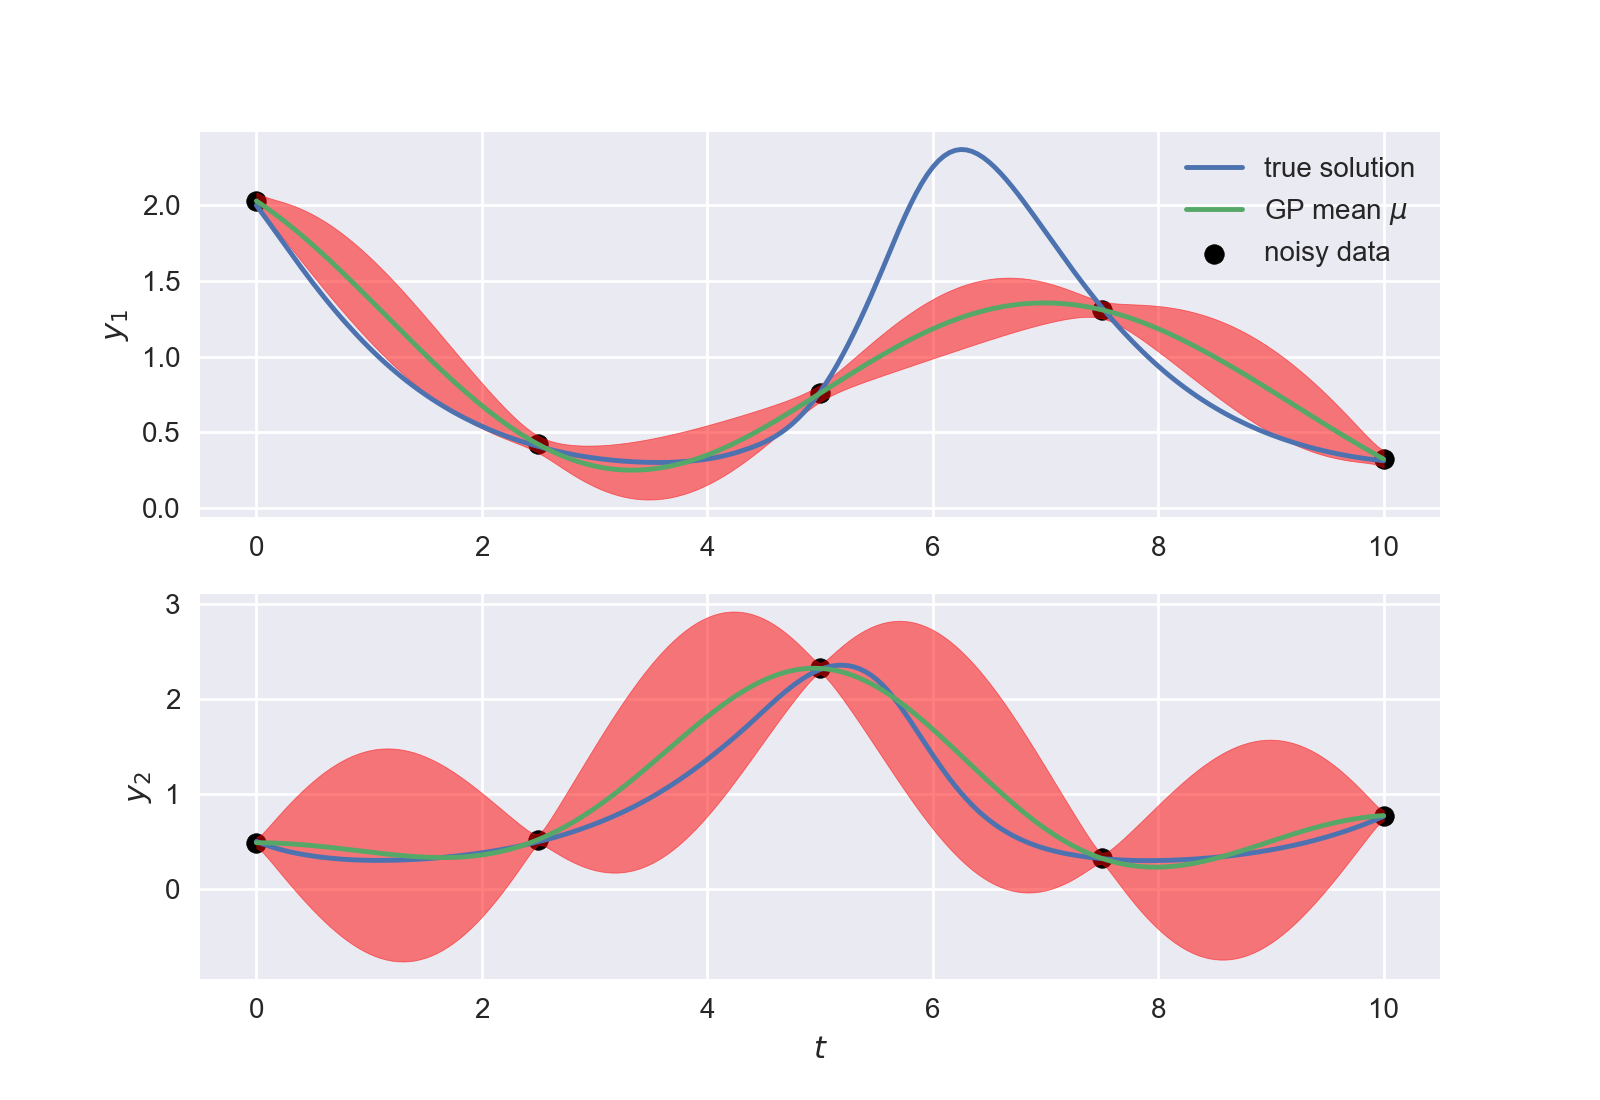

y_0 L2 relative error: 0.34118818601397155
y_1 L2 relative error: 0.1921680321572069


In [17]:
fig = plt.figure()
plt.subplot(211)
plt.ylabel('$y_1$')
plt.plot(T_sur,y_hr[0],label='true solution')
plt.scatter(T_obs,y_noisy[0],c='k',label='noisy data')
plt.plot(T_sur,mean1,label='GP mean $\mu$')
plt.fill_between(T_sur,mean1-2*np.sqrt(np.diag(cov1_gp)),mean1+2*np.sqrt(np.diag(cov1_gp)),color='r',alpha=.5)
plt.legend()
plt.subplot(212)
plt.ylabel('$y_2$')
plt.xlabel('$t$')
plt.plot(T_sur,y_hr[1],label='true')
plt.scatter(T_obs,y_noisy[1],c='k',label='noisy')
plt.plot(T_sur,mean2,label='GP')
plt.fill_between(T_sur,mean2-2*np.sqrt(np.diag(cov2_gp)),mean2+2*np.sqrt(np.diag(cov2_gp)),color='r',alpha=.5)
plt.savefig('figures/surrogate_1.pdf')
print("y_0 L2 relative error:",la.norm(y_hr[0]-mean1)/la.norm(y_hr[0]))
print("y_1 L2 relative error:",la.norm(y_hr[1]-mean2)/la.norm(y_hr[1]))

In [12]:
y2_gp.kernel_

0.904**2 * RBF(length_scale=1.13) + WhiteKernel(noise_level=0.0004)

In [13]:
# define likelihood and prior
# gaussian likelihood
def llh_sur(y):
    return -la.norm(y[0]-mean[:,0])**2 - la.norm(y[1]-mean[:,1])**2

# uniform prior
def lpr_sur(x):
    if np.all((0<x)&(x<10)):
        return 0
    else:
        return np.NINF
    
# define forward model
def f_sur(x):
    return solve_lv(T_sur,x[:2],1,x[2],x[3],1)

In [ ]:
# sample
cov = .002*np.eye(4)
X_sur = rw_metropolis_hastings(f_sur,llh_sur,lpr_sur,cov,x0,n=1000000,burn_in=10000,update=False,verbose=True)

kdes_sur = []
for col in X_sur.T:
    kdes_sur.append(gaussian_kde(col))

# Fixed noise variance, separate GP for predator and prey, precision weighted

In [ ]:
# define likelihood and prior
# gaussian likelihood
def llh_wsur(y):
    return -la.norm(W1@(y[0]-mean[:,0]))**2 - la.norm(W2@(y[1]-mean[:,1]))**2

In [ ]:
# sample
cov = .002*np.eye(4)
X_wsur = rw_metropolis_hastings(f_sur,llh_wsur,lpr_sur,cov,x0,n=1000000,burn_in=10000,update=False,verbose=True)

kdes_wsur = []
for col in X_wsur.T:
    kdes_wsur.append(gaussian_kde(col))

In [4]:
np.arange(16).reshape(4,4).ndim

2